In [100]:
from numpy import *
from pylab import plot, show
% matplotlib inline

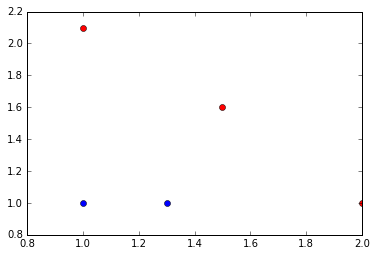

In [101]:
## 简单测试数据
def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 1.5 ,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

datMat, classLabels = loadSimpData()
t = array(classLabels)
plot(datMat[t == 1.0,0], datMat[t == 1.0,1],'ro')
plot(datMat[t == -1,0], datMat[t == -1,1],'bo')
show ()

In [133]:
# 数据分类
# return 分类结果
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    # 根据阀值分类
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0 #数据过滤
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray 
    
## 建立单层决策树——弱分类器
# return 分类器
def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0 
    bestStump = {}
    bestClasEst = mat(zeros((m,1)))
    # 将最小错误率设为 无穷大
    minError = inf #init error sum, to +infinity
    
    # 遍历每个特征特征值
    for i in range(n):#loop over all dimensions
        # 通过计算max min 来设置步长
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        
        # 对每个步长
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            
            # 对每个不等号————在大于，小于阀值间切换不等式
            for inequal in ['lt', 'gt']: #go over less than and greater than
                
                # 分类标准，也就是阀值
                threshVal = (rangeMin + float(j) * stepSize)
                
                ## stumpClassify 根据阀值分类  返回分类预测结果
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                
                #计算错误率 错误向量
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                
                # 基于权重向量D和错误情况 计算评价指标
                weightedError = D.T*errArr  #calc total error multiplied by D
                
                # print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst # 返回最佳单层决策树

In [134]:
## 使用简单测试数据测试
D = mat(ones((5,1))/5)
buildStump(datMat, classLabels,D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [135]:
# adaBoost训练方法
# return ： weakClassArr ：弱分类器集合
#          aggClassEst：   
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    #初始化
    weakClassArr = [] # 决策树数组
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    
    # 迭代
    for i in range(numIt):
        # 找到最佳单层决策树
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        
        # 计算alpha ，并更新到这棵决策树
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha 
        
        # 将找到的最佳单层决策树 加入决策树数组
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        print "classEst: ",classEst.T
        
         # 计算类别估计值
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        
        # 计算新的权重向量
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        
       
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        print "aggClassEst: ",aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        
        #错误率=0 ，退出循环
        errorRate = aggErrors.sum()/m
        print "total error: ",errorRate
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst



In [137]:
## 使用简单测试数据测试
classifierArr,aggClassEst = adaBoostTrainDS(datMat,classLabels, 30)
print classifierArr,aggClassEst

classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
classEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0
[{'dim': 0, 'ineq': 'lt', 'thresh': 1.3, 'alpha': 0.6931471805599453}, {'dim': 1, 'ineq': 'lt', 'thresh': 1.0, 'alpha': 0.9729550745276565}, {'dim': 0, 'ineq': 'lt', 'thresh': 0.90000000000000002, 'alpha': 0.8958797346140273}] [[ 1.17568763]
 [ 2.56198199]
 [-0.77022252]
 [-0.77022252]
 [ 0.61607184]]


In [128]:
# 使用训练好的数据未知分类
def adaClassify(datToClass,classifierArr):
    
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    # 遍历所有的弱分类器
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        # 显示每次迭代的后果
        # print aggClassEst
    return sign(aggClassEst) # 输出的不是1就是-1

In [138]:
## 使用简单测试数据测试 分类效果
adaClassify([[5,5],[0,0]],classifierArr)

matrix([[ 1.],
        [-1.]])

In [120]:
## 读取数据，但是可以自动检测特征值数目，
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [125]:
# test-训练分类器
dataArr, labelArr = loadDataSet('./horseColicTraining2.txt')
classifierArr02 ,aggClassEst02= adaBoostTrainDS(dataArr, labelArr,10)                           

classEst:  [[-1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
   1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
   1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1.
   1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1. -1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.
   1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.
  -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1.
  -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.
   1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.
   1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.
   1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
  -1.  1.  1.  1. -1. -1.  

In [130]:
# test -使用测试集测试分类效果
testArr, testLabelArr = loadDataSet("./horseColicTest2.txt")
prediction0 = adaClassify(testArr,classifierArr02)
print prediction0

[[ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


In [132]:
# 计算错误率
errArr = mat(ones((67,1)))
errArr [prediction0 != mat(testLabelArr).T].sum()

16.0